In [1]:
# uncomment to install gudhi on google colab

# !wget -c https://repo.continuum.io/archive/Anaconda3-5.1.0-Linux-x86_64.sh
# !chmod +x Anaconda3-5.1.0-Linux-x86_64.sh
# !bash ./Anaconda3-5.1.0-Linux-x86_64.sh -b -f -p /usr/local
# !conda remove --force -y gmpy2
# !conda install -q -y --prefix /usr/local/ -c conda-forge/label/cf201901 gudhi 

# import sys
# sys.path.append('/usr/local/lib/python3.6/site-packages/')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import random
import gudhi as gd
import itertools

import tadasets
from datetime import datetime

import ecc
import ecc_plot
import cliques_counting as cc

In [3]:
def compare_methods(points, epsilon, draw_lines=True):
    # ECC
    print("Local Simplex")
    start=datetime.now()
    c = ecc.compute_local_contributions(points, epsilon)
    print("\t time:", datetime.now()-start)
    
    e = ecc_plot.euler_characteristic_list(c)
    ecc_plot.plot_euler_curve(e, draw_lines, "Local Simplex")
    
    # cliques counting
    print("\n")
    print("Cliques counting")
    start=datetime.now()
    c = cc.compute_all_contributions_nx(points, epsilon)
    print("\t time:", datetime.now()-start)
    
    e_cc = ecc_plot.euler_characteristic_list(c)
    ecc_plot.plot_euler_curve(e_cc, draw_lines, "Cliques counting")
    
    assert((e == e_cc).all())

# TEST

## Triangle

In [3]:
point_cloud = np.array([[0, 0], [4,0], [0,3] ])

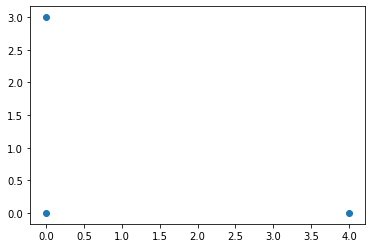

In [4]:
plt.scatter(point_cloud[: , 0], point_cloud[: , 1])

Local Simplex
	 time: 0:00:00.000833

 Cliques counting
	 time: 0:00:00.000428


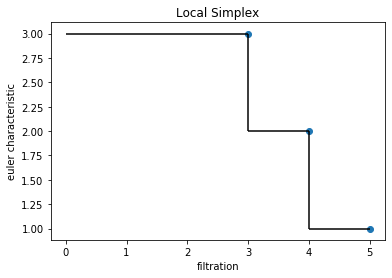

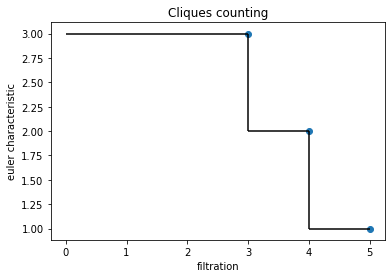

In [5]:
compare_methods(point_cloud, 10)

## Rhomboid

In [6]:
point_cloud = np.array([[4,0], [0,3.5], [-2, 0], [-0.5, -3]])

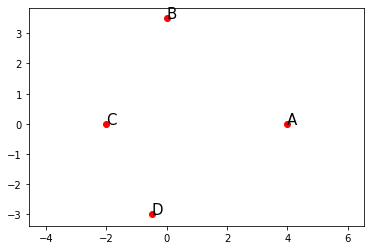

In [7]:
plt.axis('equal')
labels = ["A", "B", "C", "D"]
for i in range(len(point_cloud)):
    plt.scatter(point_cloud[i][0], point_cloud[i][1], color = "red")
    plt.text(point_cloud[i][0], point_cloud[i][1], labels[i], fontsize =15)


Local Simplex
	 time: 0:00:00.000569

 Cliques counting
	 time: 0:00:00.000547


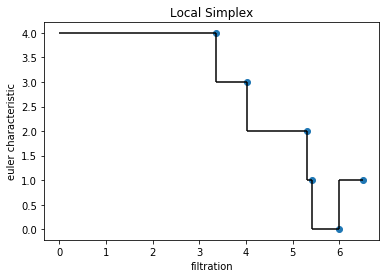

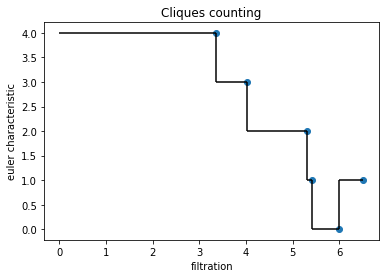

In [8]:
compare_methods(point_cloud, 10)

## Tetrahedron

In [9]:
point_cloud = np.array([[0,0,0], [0,1,0], [2,0,0], [0,0,3]])

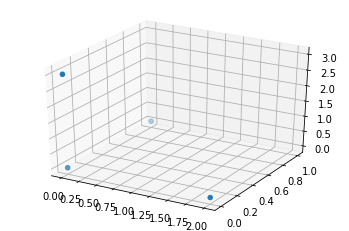

In [10]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([x[0] for x in point_cloud], [x[1] for x in point_cloud], [x[2] for x in point_cloud])

Local Simplex
	 time: 0:00:00.000616

 Cliques counting
	 time: 0:00:00.000588


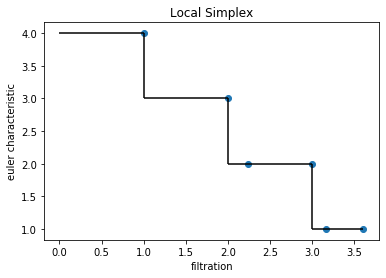

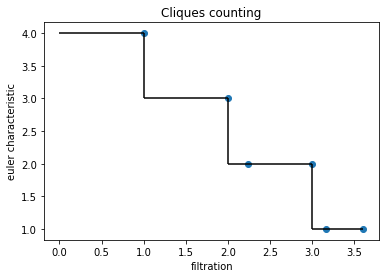

In [11]:
compare_methods(point_cloud, 10)

## Points from the example in the slides



In [12]:
point_cloud = np.array([[0,0], [2,-0.2], [4,0.2], [0,-1.5], [2,-3], [4,-1], [3.8,-2.5]] )

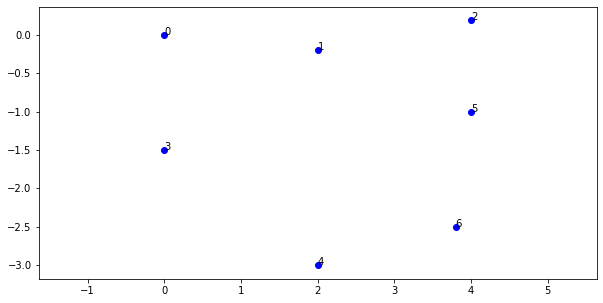

In [13]:
plt.figure(figsize=(10,5))
plt.axis('equal')
for i in range(len(point_cloud)):
    plt.scatter(point_cloud[i][0], point_cloud[i][1], color = "blue")
    plt.text(point_cloud[i][0], point_cloud[i][1], i)

Local Simplex
	 time: 0:00:00.001682


Cliques counting
	 time: 0:00:00.004253


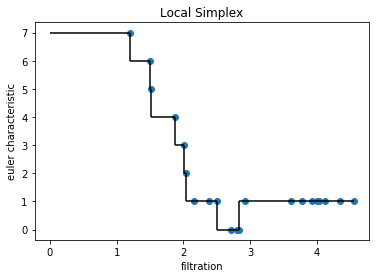

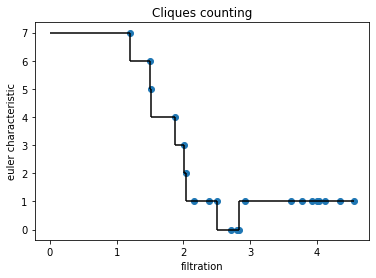

In [16]:
compare_methods(point_cloud, 10)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Circle

In [17]:
point_cloud = []

NUMBER_OF_POINTS = 20

random.seed(42)
for i in range(NUMBER_OF_POINTS):
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])
    
point_cloud = np.array(point_cloud)

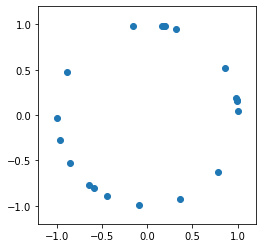

In [18]:
plt.axis('scaled')
plt.xlim((-1.2,1.2))
plt.ylim((-1.2,1.2))
plt.scatter(point_cloud[:,0], point_cloud[:,1])

Local Simplex
	 time: 0:00:12.092034


Cliques counting
	 time: 0:02:53.532790


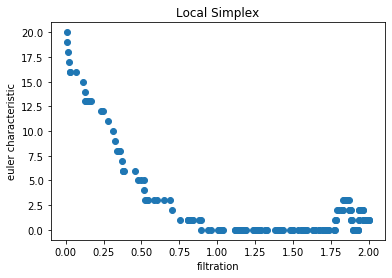

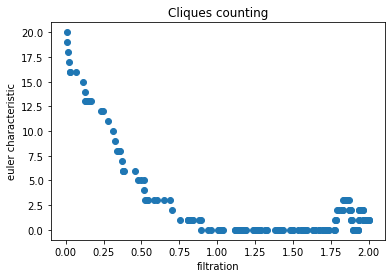

In [20]:
compare_methods(point_cloud, 2, False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Hypercube

In [4]:
# random points in the unit cube

N_POINTS = 100
DIMENSION = 3

point_cloud = np.random.rand(N_POINTS,DIMENSION)

Local Simplex
	 time: 0:00:29.644111


Cliques counting
	 time: 0:06:17.780838


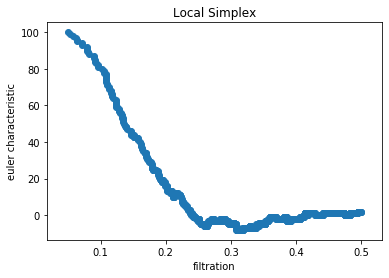

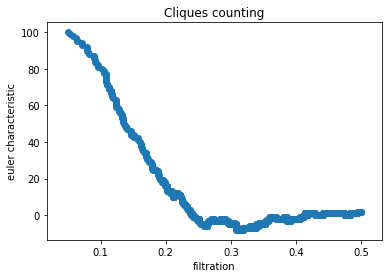

In [5]:
compare_methods(point_cloud, .5, draw_lines=False)
#rounding error

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Double circle

In [21]:
point_cloud = []

NUMBER_OF_POINTS = 25

random.seed(42)
for i in range(NUMBER_OF_POINTS):
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([np.cos(angle), np.sin(angle)])
    
    angle = random.uniform(0,2*np.pi)
    point_cloud.append([5*np.cos(angle), 5*np.sin(angle)])
    
    
point_cloud = np.array(point_cloud)

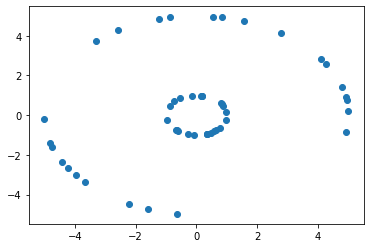

In [22]:
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])

Local Simplex
	 time: 0:00:00.062561


Cliques counting
	 time: 0:00:00.063706


AssertionError: 

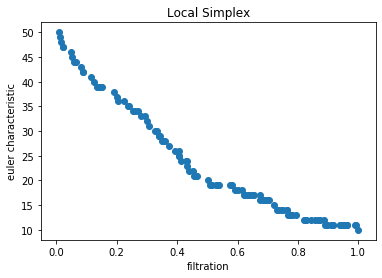

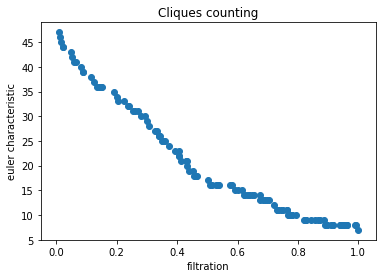

In [23]:
compare_methods(point_cloud, 1, draw_lines=False)
#rounding error

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# infinity

In [24]:
point_cloud = tadasets.infty_sign(n=50, noise=None)

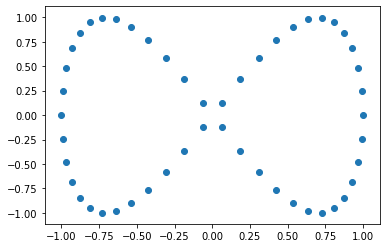

In [25]:
#plt.axis('scaled')
plt.scatter(point_cloud[:, 0], point_cloud[:, 1])

Local Simplex
	 time: 0:00:00.201082


Cliques counting
	 time: 0:00:00.871745


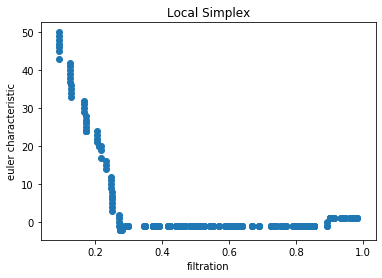

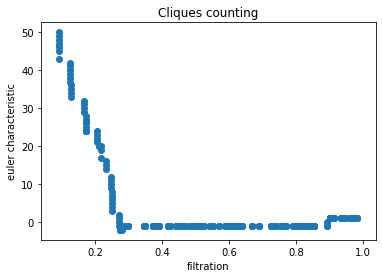

In [26]:
compare_methods(point_cloud, 1, draw_lines=False)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# n shpere

In [27]:
point_cloud = tadasets.dsphere(n=100, d=3, r=1, ambient=5, noise = 0)

Local Simplex
	 time: 0:00:00.415519


Cliques counting
	 time: 0:00:01.252118


AssertionError: 

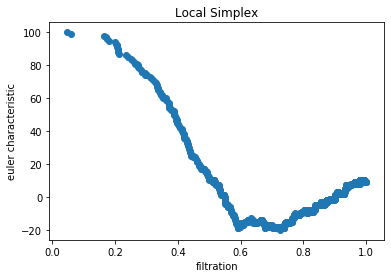

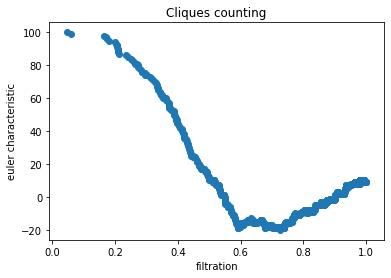

In [28]:
compare_methods(point_cloud, 1, draw_lines=False)

In [ ]:
# rounding error